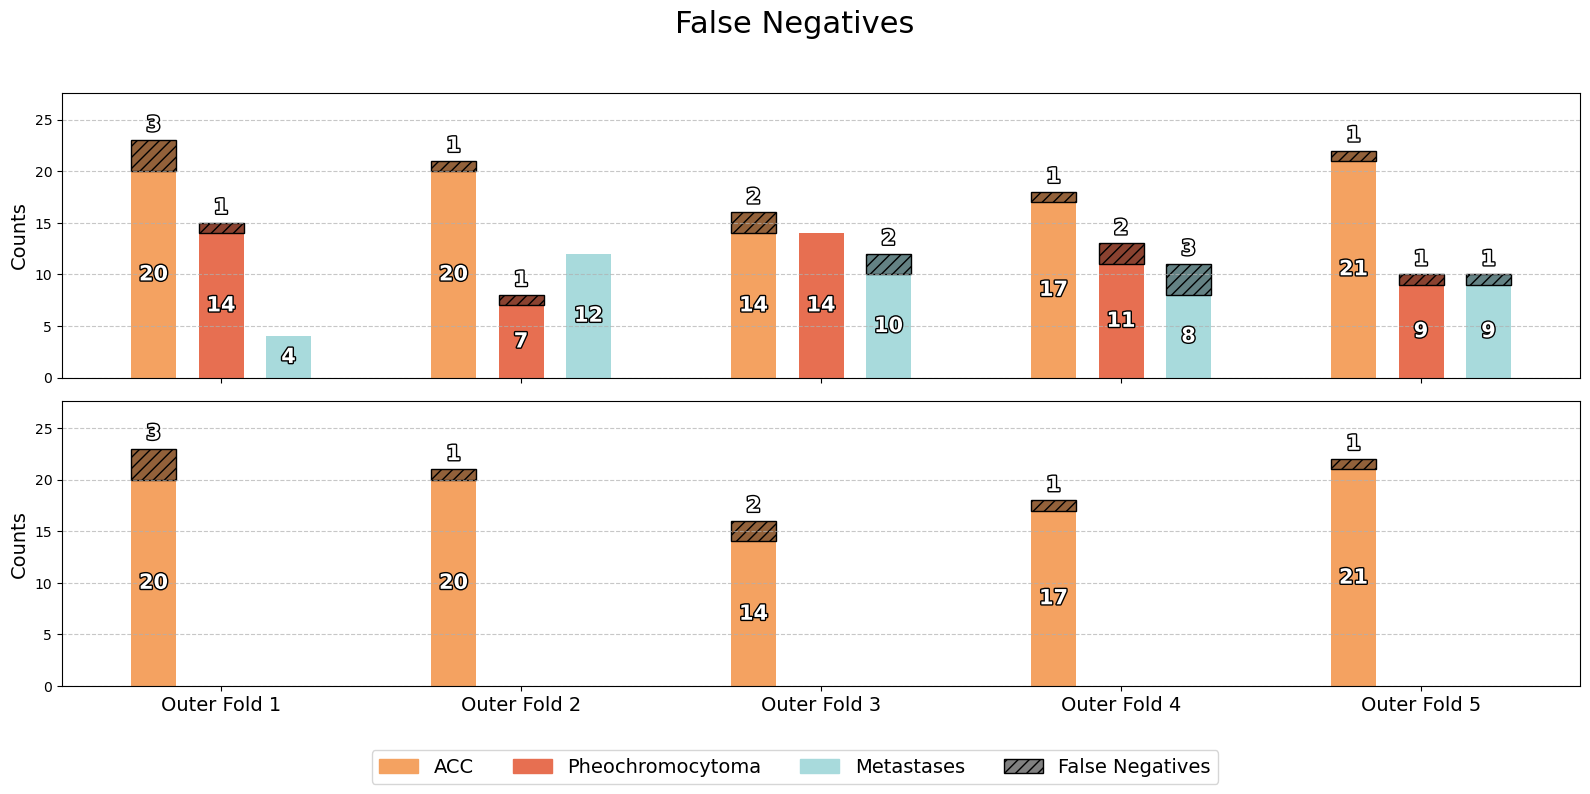

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches

folds = [
    {'Classe 2': (23, 3), 'Classe 3': (15, 1), 'Classe 4': (4, 0)},
    {'Classe 2': (21, 1), 'Classe 3': (8,  1), 'Classe 4': (12, 0)},
    {'Classe 2': (16, 2), 'Classe 3': (14, 0), 'Classe 4': (12, 2)},
    {'Classe 2': (18, 1), 'Classe 3': (13, 2), 'Classe 4': (11, 3)},
    {'Classe 2': (22, 1), 'Classe 3': (10, 1), 'Classe 4': (10,  1)}
]

class_colors = {
    'Classe 2': '#f4a261',  # pesca tenue
    'Classe 3': '#e76f51',  # terracotta soft
    'Classe 4': '#a8dadc',  # azzurro polvere chiaro
}

class_names = {
    'Classe 2': 'ACC',
    'Classe 3': 'Pheochromocytoma',
    'Classe 4': 'Metastases',
}

def darken_color(hex_color, factor=0.6):
    rgb = np.array([int(hex_color[i:i+2], 16) for i in (1,3,5)])
    darker = (rgb * factor).clip(0,255).astype(int)
    return '#' + ''.join(f'{v:02x}' for v in darker)

num_folds = len(folds)

fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

folds_row1 = folds
folds_row2 = [
    {'Classe 2': (23, 3), 'Classe 3': (0, 0), 'Classe 4': (0, 0)},
    {'Classe 2': (21, 1), 'Classe 3': (0, 0), 'Classe 4': (0, 0)},
    {'Classe 2': (16, 2), 'Classe 3': (0, 0), 'Classe 4': (0, 0)},
    {'Classe 2': (18, 1), 'Classe 3': (0, 0), 'Classe 4': (0, 0)},
    {'Classe 2': (22, 1), 'Classe 3': (0, 0), 'Classe 4': (0, 0)},
]

for row in range(2):
    ax = axs[row]
    data = folds_row1 if row == 0 else folds_row2

    x_positions = np.arange(num_folds)
    width = 0.15

    for i, fold_dict in enumerate(data):
        classes = [cls for cls in fold_dict.keys() if cls in class_colors]
        n_classes = len(classes)
        offsets = np.linspace(-width*n_classes/2, width*n_classes/2, n_classes)

        for offset, cls in zip(offsets, classes):
            total, err = fold_dict[cls]
            correct = total - err

            if correct > 0:
                ax.bar(x_positions[i] + offset, correct, width=width, color=class_colors[cls],
                       label=f'{class_names[cls]}' if (i == 0 and row == 0) else "")
                txt = ax.text(
                    x_positions[i] + offset, correct / 2, str(correct),
                    ha='center', va='center',
                    fontsize=15, fontweight='bold', color='white'
                )
                txt.set_path_effects([
                    path_effects.Stroke(linewidth=2, foreground='black'),
                    path_effects.Normal()
                ])

            if err > 0:
                ax.bar(x_positions[i] + offset, err, width=width, bottom=correct,
                       color=darken_color(class_colors[cls]), hatch='///', edgecolor='black',
                       label="")  # no label here to avoid duplicates
                txt = ax.text(
                    x_positions[i] + offset, correct + err + 0.5, str(err),
                    ha='center', va='bottom',
                    fontsize=15, fontweight='bold', color='white'
                )
                txt.set_path_effects([
                    path_effects.Stroke(linewidth=2, foreground='black'),
                    path_effects.Normal()
                ])

    ax.set_ylabel('Counts', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    max_height = max(
        max(total for cls, (total, err) in fd.items() if cls in class_colors)
        for fd in data
    )
    ax.set_ylim(0, max_height * 1.2)

axs[1].set_xticks(np.arange(num_folds))
axs[1].set_xticklabels([f'Outer Fold {i+1}' for i in range(num_folds)], fontsize=14)

# Create legend patches
class_patches = [mpatches.Patch(color=color, label=class_names[cls]) 
                 for cls, color in class_colors.items()]

# One single patch for all False Negatives (neutral gray with hatch)
fn_patch = mpatches.Patch(facecolor='gray', hatch='///', edgecolor='black', label='False Negatives')

# Combine patches
legend_handles = class_patches + [fn_patch]

fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=14)

plt.suptitle('False Negatives', fontsize=22)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig('plot_false_negatives.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
folds = [
    {'Classe 2': (23, 3), 'Classe 3': (15, 1), 'Classe 4': (4, 0)},
    {'Classe 2': (21, 1), 'Classe 3': (8,  1), 'Classe 4': (12, 0)},
    {'Classe 2': (16, 2), 'Classe 3': (14, 0), 'Classe 4': (12, 2)},
    {'Classe 2': (18, 1), 'Classe 3': (13, 2), 'Classe 4': (11, 3)},
    {'Classe 2': (22, 1), 'Classe 3': (10, 1), 'Classe 4': (10, 1)}
]

class_names = {
    'Classe 2': 'ACC',
    'Classe 3': 'Pheochromocytoma',
    'Classe 4': 'Metastases',
}

# Store FNR values per class and fold
fnr_per_class = {cls: [] for cls in class_names.keys()}

total_fn = 0
total_samples = 0

for fold in folds:
    for cls, (total, fn) in fold.items():
        fnr = fn / total if total > 0 else 0
        fnr_per_class[cls].append(fnr)

        total_fn += fn
        total_samples += total

# Calculate mean FNR per class
mean_fnr_per_class = {class_names[cls]: sum(fnr_list) / len(fnr_list) for cls, fnr_list in fnr_per_class.items()}

# Calculate overall FNR
overall_fnr = total_fn / total_samples if total_samples > 0 else 0

for cls_name, mean_fnr in mean_fnr_per_class.items():
    print(f"Mean FNR for {cls_name}: {mean_fnr:.3f} ({mean_fnr*100:.1f}%)")

print(f"\nOverall FNR (all classes combined): {overall_fnr:.3f} ({overall_fnr*100:.1f}%)")



Mean FNR for ACC: 0.081 (8.1%)
Mean FNR for Pheochromocytoma: 0.089 (8.9%)
Mean FNR for Metastases: 0.108 (10.8%)

Overall FNR (all classes combined): 0.091 (9.1%)


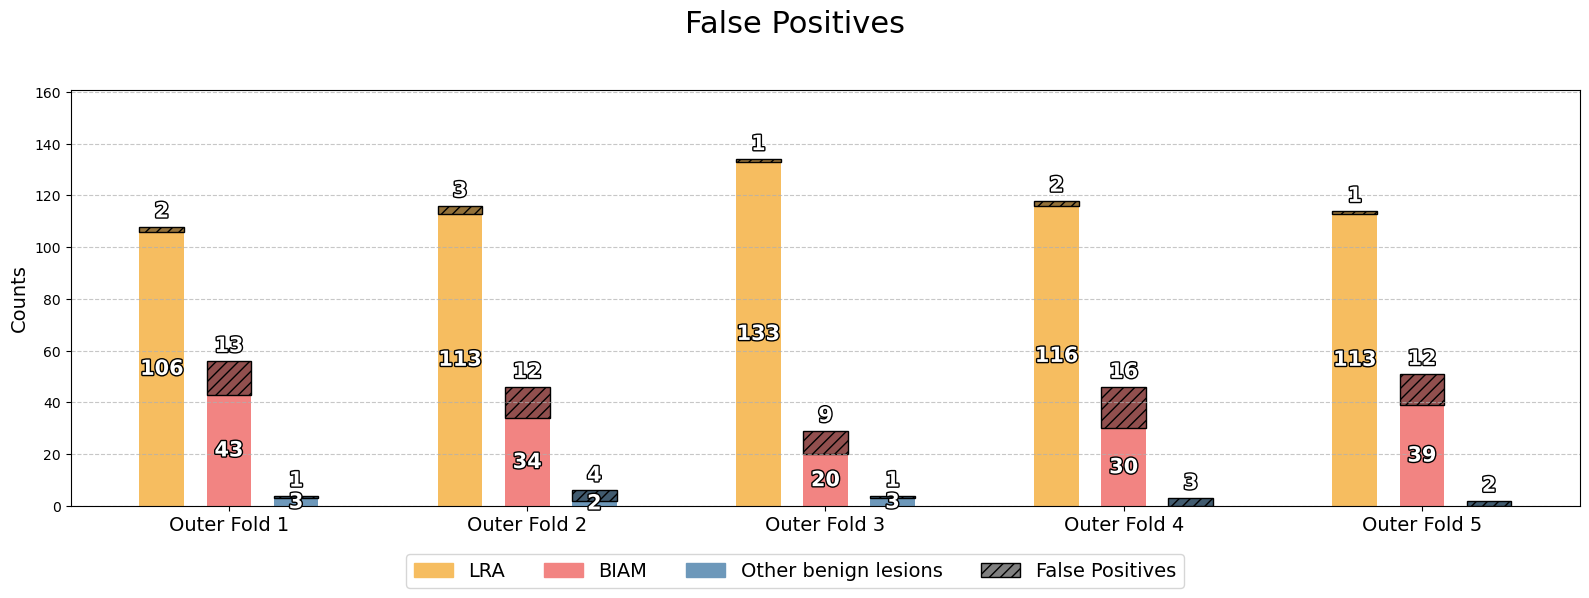

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches

# Fold data: (Total predictions, False Positives)
folds_fp = [
    {'Classe 0': (108, 2), 'Classe 1': (56, 13), 'Classe 5': (4, 1)},
    {'Classe 0': (116, 3), 'Classe 1': (46,  12), 'Classe 5': (6, 4)},
    {'Classe 0': (134, 1), 'Classe 1': (29, 9), 'Classe 5': (4, 1)},
    {'Classe 0': (118, 2), 'Classe 1': (46, 16), 'Classe 5': (3, 3)},
    {'Classe 0': (114, 1), 'Classe 1': (51, 12), 'Classe 5': (2, 2)}
]

class_colors = {
    'Classe 0': '#f6bd60',  # soft amber
    'Classe 1': '#f28482',  # coral
    'Classe 5': '#6d98ba',  # muted blue
}


class_names = {
    'Classe 0': 'LRA',
    'Classe 1': 'BIAM',
    'Classe 5': 'Other benign lesions',
}

def darken_color(hex_color, factor=0.6):
    rgb = np.array([int(hex_color[i:i+2], 16) for i in (1,3,5)])
    darker = (rgb * factor).clip(0,255).astype(int)
    return '#' + ''.join(f'{v:02x}' for v in darker)

num_folds = len(folds_fp)

fig, ax = plt.subplots(figsize=(16, 6))

x_positions = np.arange(num_folds)
width = 0.15

for i, fold_dict in enumerate(folds_fp):
    classes = [cls for cls in fold_dict if cls in class_colors]
    n_classes = len(classes)
    offsets = np.linspace(-width * n_classes / 2, width * n_classes / 2, n_classes)

    for offset, cls in zip(offsets, classes):
        total, false_pos = fold_dict[cls]
        true_pos = total - false_pos

        # True Positives
        if true_pos > 0:
            ax.bar(x_positions[i] + offset, true_pos, width=width, color=class_colors[cls],
                   label=f'{class_names[cls]}' if i == 0 else "")
            txt = ax.text(
                x_positions[i] + offset, true_pos / 2, str(true_pos),
                ha='center', va='center', fontsize=15, fontweight='bold', color='white'
            )
            txt.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])

        # False Positives
        if false_pos > 0:
            ax.bar(x_positions[i] + offset, false_pos, width=width, bottom=true_pos,
                   color=darken_color(class_colors[cls]), hatch='///', edgecolor='black',
                   label="")
            txt = ax.text(
                x_positions[i] + offset, true_pos + false_pos + 2, str(false_pos),
                ha='center', va='bottom', fontsize=15, fontweight='bold', color='white'
            )
            txt.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])

ax.set_ylabel('Counts', fontsize=14)
ax.set_xticks(np.arange(num_folds))
ax.set_xticklabels([f'Outer Fold {i+1}' for i in range(num_folds)], fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

max_height = max(
    max(total for cls, (total, _) in fd.items() if cls in class_colors)
    for fd in folds_fp
)
ax.set_ylim(0, max_height * 1.2)

# Legend
class_patches = [mpatches.Patch(color=color, label=class_names[cls]) 
                 for cls, color in class_colors.items()]
fp_patch = mpatches.Patch(facecolor='gray', hatch='///', edgecolor='black', label='False Positives')

legend_handles = class_patches + [fp_patch]
fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=14)

plt.suptitle('False Positives', fontsize=22)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig('plot_false_positives.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
import numpy as np

folds_fp = [
    {'Classe 0': (108, 2), 'Classe 1': (56, 13), 'Classe 5': (4, 1)},
    {'Classe 0': (116, 3), 'Classe 1': (46, 12), 'Classe 5': (6, 4)},
    {'Classe 0': (134, 1), 'Classe 1': (29, 9), 'Classe 5': (4, 1)},
    {'Classe 0': (118, 2), 'Classe 1': (46, 16), 'Classe 5': (3, 3)},
    {'Classe 0': (114, 1), 'Classe 1': (51, 12), 'Classe 5': (2, 2)}
]

class_names = {
    'Classe 0': 'LRA',
    'Classe 1': 'BIAM',
    'Classe 5': 'Other benign lesions',
}

fpr_per_class = {cls: [] for cls in class_names.keys()}

total_fp = 0
total_tn = 0

for fold in folds_fp:
    for cls, (tn_plus_fp, fp) in fold.items():
        fpr = fp / tn_plus_fp if tn_plus_fp > 0 else 0
        fpr_per_class[cls].append(fpr)

        total_fp += fp
        total_tn += (tn_plus_fp - fp)

mean_fpr_per_class = {class_names[cls]: round(np.mean(vals), 3) for cls, vals in fpr_per_class.items()}
overall_fpr = round(total_fp / (total_fp + total_tn), 3) if (total_fp + total_tn) > 0 else 0

# Stampa risultati
print("False Positive Rate (FPR):")
for cls_name, mean_fpr in mean_fpr_per_class.items():
    print(f" - {cls_name}: {mean_fpr:.3f} ({mean_fpr*100:.1f}%)")

print(f"\nOverall FPR: {overall_fpr:.3f} ({overall_fpr*100:.1f}%)")


False Positive Rate (FPR):
 - LRA: 0.016 (1.6%)
 - BIAM: 0.277 (27.7%)
 - Other benign lesions: 0.633 (63.3%)

Overall FPR: 0.098 (9.8%)
